In [2]:
#!pip install basicsr

In [1]:
# Check torch and cuda versions
import torch
print('Torch Version: ', torch.__version__)
print('CUDA Version: ', torch.version.cuda)
print('CUDNN Version: ', torch.backends.cudnn.version())
print('CUDA Available:', torch.cuda.is_available())

Torch Version:  2.0.1
CUDA Version:  None
CUDNN Version:  None
CUDA Available: False


In [2]:
import torchvision

In [3]:
from basicsr.archs.edvryolo_arch import EDVRYOLOFT

/Users/mansoor/opt/anaconda3/lib/python3.9/site-packages/torchvision/transforms/functional_tensor.py:5: UserWarning: The torchvision.transforms.functional_tensor module is deprecated in 0.15 and will be **removed in 0.17**. Please don't rely on it. You probably just need to use APIs in torchvision.transforms.functional or in torchvision.transforms.v2.functional.
  warnings.warn(


In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
import cv2
import torch.nn.functional as F


In [14]:
## From YYE's version, used L1 normalization on feature_maps
import torch.nn as nn
#from torchvision import transforms
import torch.nn.functional as F

class VideoPlusSegftDataset(Dataset):
    def __init__(self, file_names, ft_folder_path=".", image_folder_path=".", image_ext="png"):
        self.file_names = file_names
        self.ft_folder_path = ft_folder_path
        self.image_folder_path = image_folder_path
        self.image_ext = image_ext
        # Define a LayerNorm module with 64 channels and affine parameters
        self.layernorm = nn.LayerNorm(64)

    def __len__(self):
        return len(self.file_names)
    
    def __getitem__(self, idx):

            file_name = self.file_names[idx]

            image_np = cv2.imread(f"{self.image_folder_path}/{file_name}.{self.image_ext}")
            image_np = cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB)
            image_tensor = torch.from_numpy(image_np).float().permute(2, 0, 1) / 255.0

            # Normalize the image tensor using ImageNet mean and std
            mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
            std = torch.tensor([0.229, 0.124, 0.125]).view(3, 1, 1)
            normalized_image_tensor = (image_tensor - mean) / std

            feature_maps_l0 = torch.load(f'{self.ft_folder_path}/{file_name}_fm_l0.pt')
            feature_maps_l1 = torch.load(f'{self.ft_folder_path}/{file_name}_fm_l1.pt')
            feature_maps_l2 = torch.load(f'{self.ft_folder_path}/{file_name}_fm_l2.pt')

            # Normalize the feature maps using L1 norm over channel dimension
            #feature_maps_l0 = F.normalize(feature_maps_l0[0], p=1, dim=1)
            #feature_maps_l1 = F.normalize(feature_maps_l1[0], p=1, dim=1)
            #feature_maps_l2 = F.normalize(feature_maps_l2[0], p=1, dim=1)

            return normalized_image_tensor.repeat(5, 1, 1, 1), \
                    feature_maps_l0.repeat(5, 1, 1, 1), \
                        feature_maps_l1.repeat(5, 1, 1, 1), \
                            feature_maps_l2.repeat(5, 1, 1, 1)


In [19]:
filen_names= ['woman']

In [20]:
dataset = VideoPlusSegftDataset(filen_names)

In [21]:
dataLoader = DataLoader(dataset, batch_size=1)

In [22]:
model = EDVRYOLOFT(num_in_ch=3, num_out_ch=3, with_tsa=True)
for sample in dataLoader:
    output = model(sample)

In [23]:
output.shape

torch.Size([1, 3, 448, 304])

### Visualization

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# Load the RGB image from disk
image = plt.imread('./GT_woman.png')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


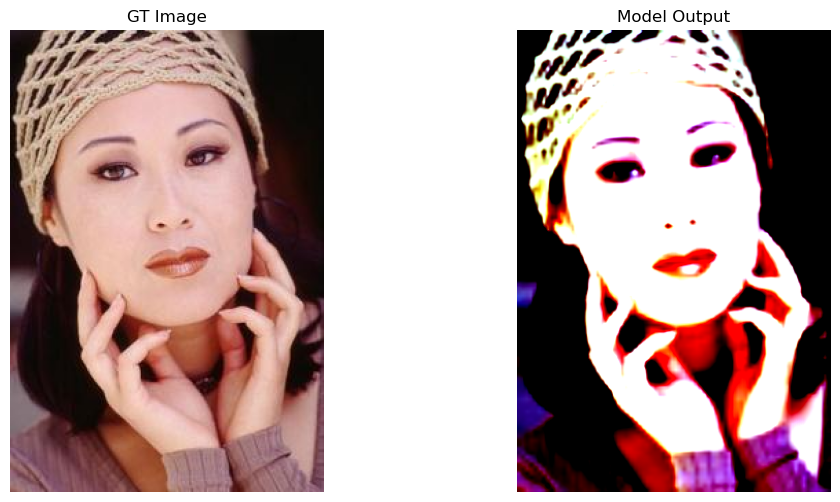

In [25]:
image_numpy = output[0].detach().numpy()
output_np = np.transpose(image_numpy, (1, 2, 0))

# Create a subplot with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the original image
axs[0].imshow(image)
axs[0].axis('off')
axs[0].set_title('GT Image')

# Plot the model output
axs[1].imshow(output_np)
axs[1].axis('off')
axs[1].set_title('Model Output')

plt.show()

### Result: Normalization on feature maps does not change the image for SR 


### PSNR test

In [27]:
import cv2
import numpy as np

def calculate_psnr(original_img, reconstructed_img):
    mse = np.mean((original_img - reconstructed_img) ** 2)
    max_pixel_value = 255.0  # Assuming 8-bit images
    psnr = 10 * np.log10((max_pixel_value ** 2) / mse)
    return psnr

# Load the original and reconstructed images (assuming they are in the same directory)
original_img = cv2.imread("/Users/mansoor/Documents/TUS/3rd_Semester_Dessertation/edvryolov8_v1/GT_woman.png")  # Replace with your original image path


original_img_np =  np.array(original_img)
print (original_img_np.shape)

reconstructed_img_np = output_np  # Replace with your actual tensor

def crop_center(img, target_shape):
    y, x, _ = img.shape
    target_y, target_x, _ = target_shape
    start_x = x//2 - (target_x//2)
    start_y = y//2 - (target_y//2)
    return img[start_y:start_y+target_y, start_x:start_x+target_x, :]

# Crop the larger image to match the smaller one
if original_img_np.shape != reconstructed_img_np.shape:
    if original_img_np.shape[0] > reconstructed_img_np.shape[0]:
        original_img_np = crop_center(original_img_np, reconstructed_img_np.shape)
    else:
        reconstructed_img_np = crop_center(reconstructed_img_np, original_img_np.shape)


print(reconstructed_img_np.shape)
# Calculate PSNR
psnr_score = calculate_psnr(original_img_np, reconstructed_img_np)

print(f"PSNR: {psnr_score:.2f} dB")


(336, 228, 3)
(336, 228, 3)
PSNR: 5.03 dB
